# Clustering de Zonas Geológicas

El clustering de zonas geológicas es una técnica de agrupamiento que permite identificar patrones y similitudes entre diferentes intervalos geológicos dentro de un pozo o entre múltiples pozos. Estas agrupaciones son útiles para entender el comportamiento del yacimiento, identificar zonas con características similares y optimizar estrategias de desarrollo, como la selección de fluidos de inyección o el diseño de estimulaciones.

El análisis considera variables clave como la **permeabilidad**, **porosidad** y el **diámetro de garganta de poro (R35)**, que se calcula a partir de la permeabilidad y porosidad mediante una relación empírica. Estas características geológicas se analizan para identificar clusters que representan diferentes zonas del yacimiento.


## Contenido
- [1 - Introducción](#1)
  - [1.1 Objetivo](#1.1)
- [2 - Imports Necesarios](#2)
- [3 - Exploración](#3)
  - [3.1 Datos](#3.1)
  - [3.2 Visualización](#3.2)
- [4 - Funciones Auxiliares](#4)
  - [4.1 - Cálculo del R35](#4.1)
  - [4.2 - Función de Escalado](#4.2)
- [5 - Clustering K-Means](#5)
- [6 - Clustering DBSCAN](#6)
- [7 - Evaluación del Clustering](#7)
  - [7.1 Visualización](#7.1)
  - [7.2 Métricas de Evaluación](#7.2)


<a name="1"></a>

## 1 - Introducción 
En este notebook, exploraremos el uso de técnicas de clustering para identificar patrones y similitudes en zonas geológicas de pozos petroleros. El análisis se centrará en agrupar zonas con características geológicas similares utilizando variables clave como:
1. Permeabilidad (mD).
2. Porosidad (%).
3. Diámetro de garganta de poro (R35).

Estas técnicas permiten identificar grupos homogéneos dentro de un yacimiento, lo que facilita la toma de decisiones para optimizar estrategias de inyección, estimulación y desarrollo del campo.

<a name="1.1"></a>

### 1.1 Objetivo

El objetivo de este estudio es aplicar algoritmos de clustering para identificar y analizar zonas geológicas con comportamientos similares dentro de uno o varios pozos. Usaremos datos históricos de mediciones geológicas (permeabilidad, porosidad y R35) para descubrir patrones que apoyen la planificación y optimización de las operaciones. Este análisis se realizará sobre un conjunto de datos estructurado en formato csv.


<a name="2"></a>
## 2 - Imports Necesarios

El siguiente bloque de código importará las bibliotecas necesarias para ejecutar este notebook..

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'

<a name="2"></a>
## 3 - Exploración


<a name="3.1"></a>

### 3.1 Datos

Los datos utilizados en este análisis están almacenados en un archivo CSV y contienen las siguientes Columnas:
* depth
* permeability (mD)
* porosity (%)

Se encuentran valores de permeabilidad y porosidad cada 0.5 ft

In [165]:
df=pd.read_csv('garganta_poro.csv')

In [166]:
#Se revisan los primeros 5 registros
df.head()

,depth,permeability,porosity,Pozo
0,7159.5,0.0,0.0,well1
1,7160.0,0.0,0.0,well1
2,7160.5,0.0,0.0,well1
3,7161.0,0.0,0.0,well1
4,7161.5,0.0,0.0,well1


In [167]:
#Se verifica el tipo de datos
df.dtypes

depth           float64
permeability    float64
porosity        float64
Pozo             object
dtype: object

In [168]:
#Verificación de Estadísticas del df
print(f'Estadísticas:\n{df.describe()}\n')

print(f'Valores Faltantes:\n{df.isnull().sum()}')

Estadísticas:
              depth  permeability      porosity
count  23719.000000  2.370700e+04  23712.000000
mean    7942.802247  1.738222e+05     10.230358
std      478.857097  1.124583e+06     43.610140
min     7060.000000  0.000000e+00      0.000000
25%     7568.500000  1.900000e-03      0.003200
50%     7897.750000  2.599044e+02      0.155300
75%     8218.125000  3.545505e+03      0.214600
max     9260.000000  1.995900e+07    335.000000

Valores Faltantes:
depth            0
permeability    12
porosity         7
Pozo             0
dtype: int64


Se observa que existen 12 valores faltantes con respecto la columna permeability y 7 conrespecto la columna porosity, en este tipo de casos hay que elegir cual es la mejor opción a reliazar si imputamos un valor anterior para rrelennar el faltante o tomamos alguna métrica de centralización como la media o eliminamos las filas con datos faltantes.

In [169]:
print(f'Datos Faltantes a partir de columna porosidad:\n{df[df['porosity'].isna()]}\n')
print(f'Datos Faltantes a partir de columna Permeabilidad:\n{df[df['permeability'].isna()]}')

Datos Faltantes a partir de columna porosidad:
        depth  permeability  porosity    Pozo
1212   7765.5           NaN       NaN   well1
3544   7791.0           NaN       NaN   well2
5685   8043.5           NaN       NaN   well3
9672   8805.5           NaN       NaN   well5
18429  7822.0           NaN       NaN   well8
20224  7545.0           NaN       NaN   well9
22720  8761.0           NaN       NaN  well10

Datos Faltantes a partir de columna Permeabilidad:
        depth  permeability  porosity    Pozo
1212   7765.5           NaN       NaN   well1
2211   8265.0           NaN    0.2048   well1
3544   7791.0           NaN       NaN   well2
4347   8192.5           NaN    0.0000   well2
5685   8043.5           NaN       NaN   well3
6273   8337.5           NaN    0.0000   well3
7977   8032.0           NaN    0.1826   well4
9672   8805.5           NaN       NaN   well5
18429  7822.0           NaN       NaN   well8
19253  8234.0           NaN    0.0000   well8
20224  7545.0           NaN

In [170]:
#Eliminamos los datos faltantes y revisamos si ya no existen en la data
df=df.dropna()
print(f'verificación de nulos luego de eliminarlos:\n{df.isnull().sum()}')

verificación de nulos luego de eliminarlos:
depth           0
permeability    0
porosity        0
Pozo            0
dtype: int64


In [171]:
df.describe()

,depth,permeability,porosity
count,23707.000000,2.370700e+04,23707.00000
mean,7942.706036,1.738222e+05,10.23250
std,478.887293,1.124583e+06,43.61449
min,7060.000000,0.000000e+00,0.00000
25%,7568.125000,1.900000e-03,0.00320
50%,7897.500000,2.599044e+02,0.15530
75%,8218.000000,3.545505e+03,0.21460
max,9260.000000,1.995900e+07,335.00000


Con respecto de la columnas porosity y permeability se decide eliminar los valores faltantes ya que solo representan una porción muy pequeña de data por cada pozo.

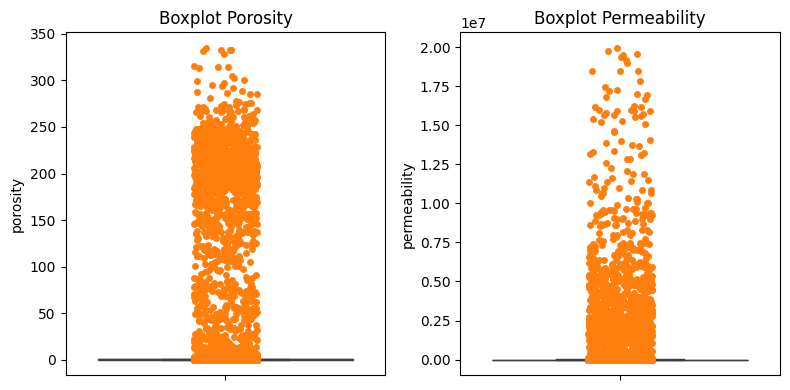

In [172]:
fig, axes=plt.subplots(1,2,figsize=(8,4), sharey=False)

#Boxplot Porosity
sns.boxplot(df['porosity'], ax=axes[0],fliersize=False)
sns.stripplot(df['porosity'], ax=axes[0])
axes[0].set_title("Boxplot Porosity")

#Boxplot Permeability
sns.boxplot(df['permeability'], ax=axes[1], fliersize=False)
sns.stripplot(df['permeability'], ax=axes[1])
axes[1].set_title("Boxplot Permeability")

fig.tight_layout()

plt.show()

In [173]:
#Revisar cuantos valores atípicos se encuentran por cada variable

Q1=df['porosity'].quantile(0.25)
Q3=df['porosity'].quantile(0.75)
IQR=Q3-Q1

# La literatura habla de que un valor es atípico moderado si es mayor a Q3+1.5IQR  o menor a Q1-1.5IQR, es un valor atípico extremo 
# si es mayor a Q3+3IQR o menor a Q1-3IQR
moderado_derecha_por= Q3+1.5*IQR
moderado_izquierda_por=Q1-1.5*IQR

print(f'corte para valores atípicos moderados:{round(moderado_derecha_por,2)}')


extremo_derecha_por=Q3+3*IQR
extremo_izquierda_por=Q1-3*IQR

print(f'corte para valores atípicos extremos: {round(extremo_derecha_por,2)}')

corte para valores atípicos moderados:0.53
corte para valores atípicos extremos: 0.85


In [174]:
Q1=df['permeability'].quantile(0.25)
Q3=df['permeability'].quantile(0.75)
IQR=Q3-Q1

moderado_derecha_per=Q3+1.5*IQR
moderado_izquierda_per=Q1-1.5*IQR

print(f'corte para valores atípicos moderados hacia la derecha permeability: {int(moderado_derecha_per)}')


extremo_derecha_per=Q3+3*IQR
extremo_izquierda_per=Q1-3*IQR


print(f'corte para valores atípicos extremos hacia la derecha permeability: {int(extremo_derecha_per)}')

corte para valores atípicos moderados hacia la derecha permeability: 8863
corte para valores atípicos extremos hacia la derecha permeability: 14182


Con base en la literatura y mediciones realizadas en rocas sedimentarias, se reconoce que la porosidad en areniscas típicamente no supera el 30%. Valores más altos, entre 40% y 50%, suelen estar relacionados con procesos como la disolución de foraminíferos o el desarrollo de porosidad secundaria. Estas condiciones no representan una capacidad efectiva de almacenamiento, ya que generalmente no existe interconexión entre los poros. Según Tiab y Donaldson (2015) en Petrophysics: Theory and Practice of Measuring Reservoir Rock and Fluid Transport Properties, este fenómeno es ampliamente descrito y estudiado. Por lo tanto, para los análisis presentes, se excluirán los valores superiores al límite atípico moderado de 0.53.
 

In [175]:
print(f'total de observaciones variable porosity antes de quitar atípicos: {len(df['porosity'])}')
print(f'total de observaciones variable porosity antes de quitar atípicos: {len(df[df['porosity']>moderado_derecha_por])}\n')

print(df[df['porosity']>moderado_derecha_por].head())

#Creamos una columna para identificar la data outliers_permeability
df['outliers_porosity']=df['porosity']>moderado_derecha_por

validos=df[~df['outliers_porosity']]

total de observaciones variable porosity antes de quitar atípicos: 23707
total de observaciones variable porosity antes de quitar atípicos: 1716

     depth  permeability  porosity   Pozo
24  7171.5     3416.4148     203.0  well1
27  7173.0     3056.7000     202.0  well1
42  7180.5     1578.1553     185.0  well1
51  7185.0     2149.1848     192.0  well1
68  7193.5        3.2621      63.0  well1


In [176]:
print(f'total de observaciones variable permeability : {len(df['permeability'])}')
print(f'total de observaciones variable permeability : {len(df['permeability'])}')


total de observaciones variable permeability : 23707
total de observaciones variable permeability : 23707


Se observa con la data que está por encima del valor moderado atípico que las porosidades evidentemente no tienen sentido, pero el valor correspondiente a esa profunidad de permeabilidad son validos por lo que se puede tratar de buscar una forma de cambiar esos valores de porosidades por valores basados en un modelo entre la profundidad, permeabilidad y porosidad para tratar de predecir en base a la profundidad y permeabilidad el valor de porosidad, si no la solución seria eliminar los 1716 registros con este problema.